## NHITS in NeuralForecast
- Source code: https://nixtlaverse.nixtla.io/neuralforecast/models.nhits.html

In [1]:
!pip install neuralforecast
# !pip install torch
# !pip install torch torchvision torchaudio

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Air Passenger (Monthly dataset)
- H=12, L=24

In [3]:
AirPassengersPanel['ds'].values[-12]

numpy.datetime64('1960-01-31T00:00:00.000000000')

In [4]:
AirPassengersPanel

,unique_id,ds,y,trend,y_[lag12]
0,Airline1,1949-01-31,112.0,0,112.0
1,Airline1,1949-02-28,118.0,1,118.0
2,Airline1,1949-03-31,132.0,2,132.0
3,Airline1,1949-04-30,129.0,3,129.0
4,Airline1,1949-05-31,121.0,4,121.0
...,...,...,...,...,...
283,Airline2,1960-08-31,906.0,283,859.0
284,Airline2,1960-09-30,808.0,284,763.0
285,Airline2,1960-10-31,761.0,285,707.0
286,Airline2,1960-11-30,690.0,286,662.0


In [5]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

In [6]:
Y_test_df

,unique_id,ds,y,trend,y_[lag12]
0,Airline1,1960-01-31,417.0,132,360.0
1,Airline1,1960-02-29,391.0,133,342.0
2,Airline1,1960-03-31,419.0,134,406.0
3,Airline1,1960-04-30,461.0,135,396.0
4,Airline1,1960-05-31,472.0,136,420.0
5,Airline1,1960-06-30,535.0,137,472.0
6,Airline1,1960-07-31,622.0,138,548.0
7,Airline1,1960-08-31,606.0,139,559.0
8,Airline1,1960-09-30,508.0,140,463.0
9,Airline1,1960-10-31,461.0,141,407.0


In [7]:
model = NHITS(h=12,
              input_size=24,
              loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
              stat_exog_list=['airline1'],
              futr_exog_list=['trend'],
              n_freq_downsample=[2, 1, 1],
              scaler_type='robust',
              max_steps=200,
              early_stop_patience_steps=2,
              inference_windows_batch_size=1,
              val_check_steps=10,
              learning_rate=1e-3)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [8]:
fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 2.5 M  | train
----------------------------------------------------------
2.5 M     Trainable params
5         Non-trainable params
2.5 M     Total params
10.046    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


[]

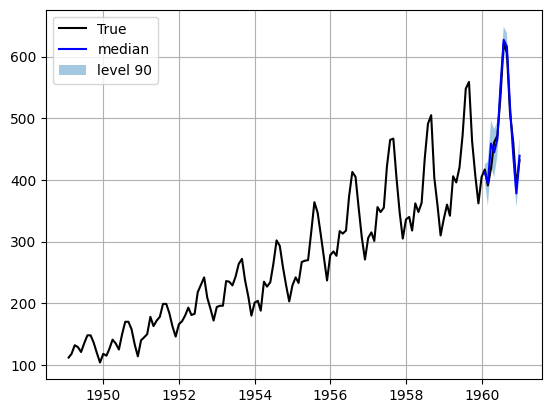

In [9]:
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NHITS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['NHITS-lo-90'][-12:].values,
                 y2=plot_df['NHITS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

## NHITS in Pytorch-Forecasting

In [1]:
#runtime re-connect (런타임 연결해제 및 삭제)
#!pip install pytorch-lightning==2.0.1.post0 sktime pytorch-forecasting==1.0.0
!pip install sktime pytorch-forecasting==1.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import EarlyStopping

import lightning as L
from lightning.pytorch.callbacks import EarlyStopping

from pytorch_forecasting import Baseline, NBeats, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

import torch
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import random

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.ets import AutoETS
from sktime.transformations.bootstrap import STLBootstrapTransformer
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.conformal import ConformalIntervals

from sktime.transformations.series.fourier import FourierFeatures
from sktime.transformations.series.lag import Lag

In [4]:
print(L.__version__)
print(torch.__version__)

# pytorch-forecasting==1.0.0
# pytorch-lightning==2.0.1.post0

2.4.0
2.4.1+cu121


## Microbusiness Density Forecasting
- 이 대회의 목표는 **미국 카운티별 월별 마이크로비즈니스 밀도를 예측**하는 것임.
- 마이크로비즈니스는 일반적으로 직원 수 10명 이하의 소규모 사업체로, 주로 온라인에서 활동.
- 대회 주최자인 GoDaddy는 2천만 개 이상의 마이크로비즈니스 데이터를 수집해왔음.
- 정확한 예측을 통해 정책 입안자들은 기존 데이터에서 잘 드러나지 않는 소규모 사업체에 대한 중요한 통찰을 얻을 수 있음.
- Source: https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/overview

In [6]:
train_data = pd.read_csv("/content/godaddy-microbusiness-density-forecasting/train.csv")
test_data = pd.read_csv("/content/godaddy-microbusiness-density-forecasting/test.csv")
census_data = pd.read_csv("/content/godaddy-microbusiness-density-forecasting/census_starter.csv")
#subm = pd.read_csv("/content/godaddy-microbusiness-density-forecasting/sample_submission.csv")

### Task
- 제공된 데이터에는 훈련용 데이터(train.csv), 테스트용 메타데이터(test.csv), 샘플 제출 파일(sample_submission.csv), 그리고 인구 조사 데이터를 포함한 추가적인 정보(census_starter.csv)가 포함됨.
- train.csv
    - row_id: 각 행에 대한 ID 코드.
    - cfips: 카운티를 식별하는 고유 코드(FIPS 시스템 기반).
    - county_name: 카운티의 이름.
    - state_name: 주의 이름.
    - first_day_of_month: 월의 첫 번째 날.
    - microbusiness_density: 18세 이상 인구 100명당 마이크로비즈니스 수 (목표 변수).
    - active: 카운티 내 마이크로비즈니스 수 (테스트 세트에는 제공되지 않음).
- census_starter.csv: 미국 인구 조사국의 데이터를 기반으로 한 유용한 컬럼들.
    - pct_bb_[year]: 가구의 인터넷 사용률.
    - pct_college_[year]: 25세 이상 인구 중 4년제 대학 졸업자의 비율.
    - pct_foreign_born_[year]: 외국 출생자의 비율.
    - pct_it_workers_[year]: 정보 관련 산업 종사자 비율.
    - median_hh_inc_[year]: 가구 중위 소득.

In [7]:
all_data = pd.concat((train_data, test_data)).sort_values(['cfips','row_id']).reset_index(drop=True)

In [8]:
all_data["time_idx"] = all_data.groupby("cfips").cumcount()

In [9]:
all_data[all_data["cfips"] == 1001].tail(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,time_idx
37,1001_2022-09-01,1001,Autauga County,Alabama,2022-09-01,3.442677,1463.0,37
38,1001_2022-10-01,1001,Autauga County,Alabama,2022-10-01,3.463856,1472.0,38
39,1001_2022-11-01,1001,NaN,NaN,2022-11-01,NaN,NaN,39
40,1001_2022-12-01,1001,NaN,NaN,2022-12-01,NaN,NaN,40
41,1001_2023-01-01,1001,NaN,NaN,2023-01-01,NaN,NaN,41
42,1001_2023-02-01,1001,NaN,NaN,2023-02-01,NaN,NaN,42
43,1001_2023-03-01,1001,NaN,NaN,2023-03-01,NaN,NaN,43
44,1001_2023-04-01,1001,NaN,NaN,2023-04-01,NaN,NaN,44
45,1001_2023-05-01,1001,NaN,NaN,2023-05-01,NaN,NaN,45
46,1001_2023-06-01,1001,NaN,NaN,2023-06-01,NaN,NaN,46


In [10]:
all_data.dtypes

,0
row_id,object
cfips,int64
county,object
state,object
first_day_of_month,object
microbusiness_density,float64
active,float64
time_idx,int64


In [11]:
VAL_LEN = 8
val_inds = np.arange(39-VAL_LEN,39)

TEST_LEN = 8
test_inds = np.arange(39,47)

train_inds = np.arange(39-VAL_LEN)
TRAIN_LEN = len(train_inds)

train_val_inds = np.arange(39)

train_inds, val_inds, test_inds

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 array([31, 32, 33, 34, 35, 36, 37, 38]),
 array([39, 40, 41, 42, 43, 44, 45, 46]))

In [12]:
batch_size = 128

In [13]:
train_val_data = all_data[all_data["time_idx"].isin(train_val_inds)][["cfips", "microbusiness_density", "time_idx"]]

train_dataset = TimeSeriesDataSet(
    train_val_data,
    group_ids=["cfips"],
    target="microbusiness_density",
    time_idx="time_idx",
    max_encoder_length=TRAIN_LEN,
    max_prediction_length=VAL_LEN,
    time_varying_unknown_reals=["microbusiness_density"],
)

val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, train_val_data, min_prediction_idx=val_inds[0])
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=4, pin_memory = True)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4, pin_memory = True)

In [14]:
train_dataset.__len__()

3135

In [15]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [16]:
SMAPE()(baseline_predictions, actuals.to('cuda:0'))

tensor(0.0364, device='cuda:0')

In [17]:
model_param = {
    "batch_normalization": True,
    "n_layers": 2,
    "n_blocks": [1, 1, 1],
    "hidden_size": 64,
}

In [19]:
#pl.seed_everything(42)
#trainer = pl.Trainer(gradient_clip_val=0.01)

net = NHiTS.from_dataset(
    train_dataset,
    learning_rate=3e-2,
    weight_decay=1e-2,
    backcast_loss_ratio=0.1,
    optimizer='adam',
    **model_param
)

In [20]:
net.size()

23338

In [21]:
trainer = L.Trainer(max_epochs=100, gradient_clip_val=0.01)
tuner = L.pytorch.tuner.Tuner(trainer)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [22]:
# find optimal learning rate
res = tuner.lr_find(
                    net,
                    train_dataloaders=train_dataloader,
                    val_dataloaders=val_dataloader,
                    min_lr=1e-5)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.005623413251903493
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.005623413251903493
INFO: Restoring states from the checkpoint path at /content/.lr_find_6dbc6666-6e07-40b4-9c83-baed5d79727f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_6dbc6666-6e07-40b4-9c83-baed5d79727f.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_6dbc6666-6e07-40b4-9c83-baed5d79727f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_6dbc6666-6e07-40b4-9c83-baed5d79727f.ckpt


suggested learning rate: 0.005623413251903493


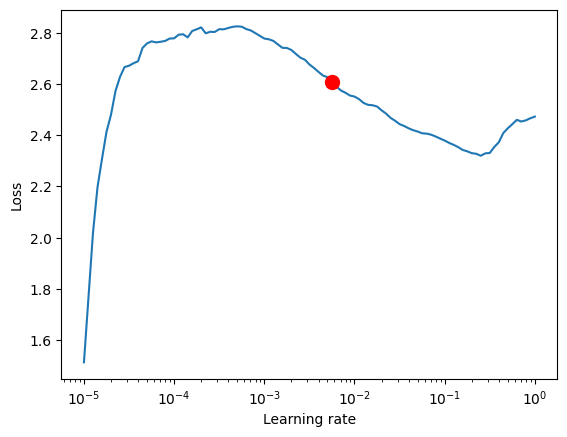

In [23]:
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [24]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = L.Trainer(
    max_epochs=15,
    accelerator = "gpu",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    log_every_n_steps = 10,
)


net = NHiTS.from_dataset(
    train_dataset,
    learning_rate=res.suggestion(),
    log_interval=1,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=1.0,
    optimizer='adam',
    **model_param
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | MASE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 23.3 K | train
-----------------------------------------------------------
23.3 K    Trainable params
0         Non-trainable params
23.3 K    Total params
0.093     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | MASE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embed

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [33]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cuda:0')
predictions = net.predict(val_dataloader)
(actuals - predictions).abs().mean()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.1878, device='cuda:0')

In [44]:
raw_predictions, x, _, _, _ = net.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


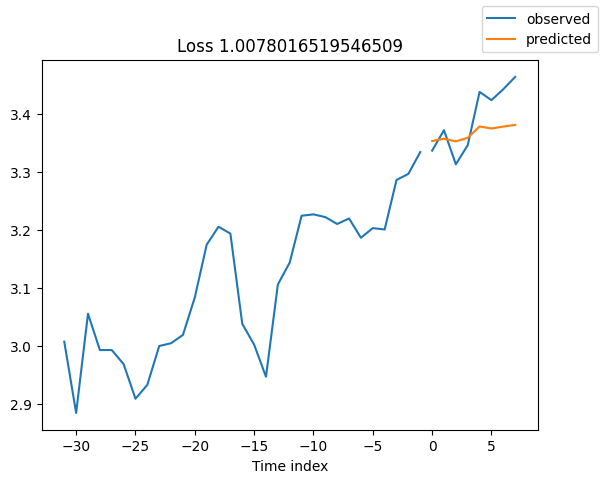

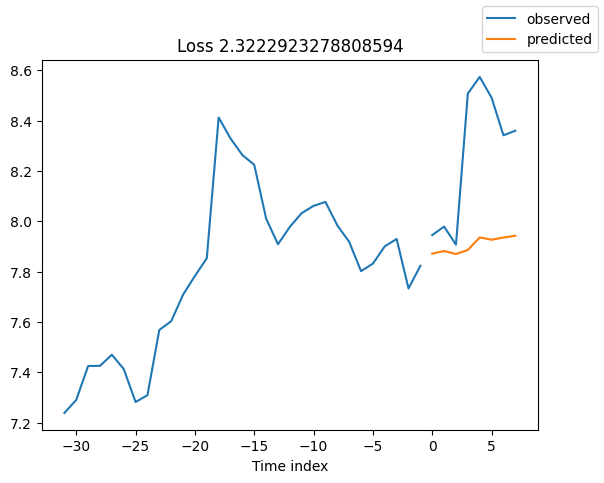

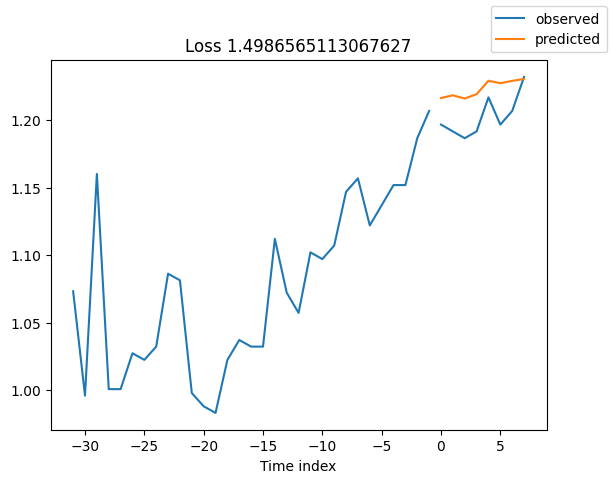

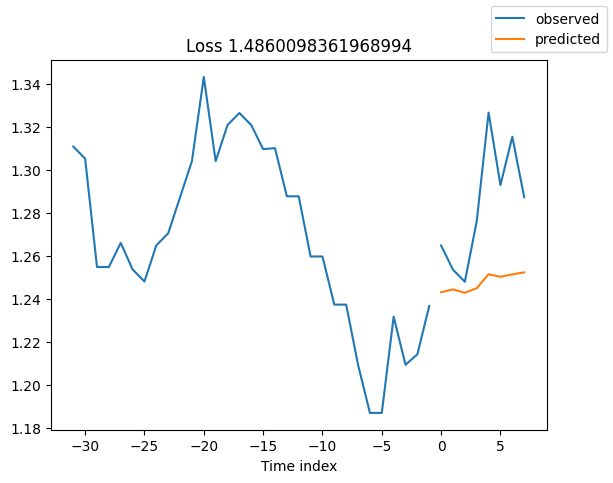

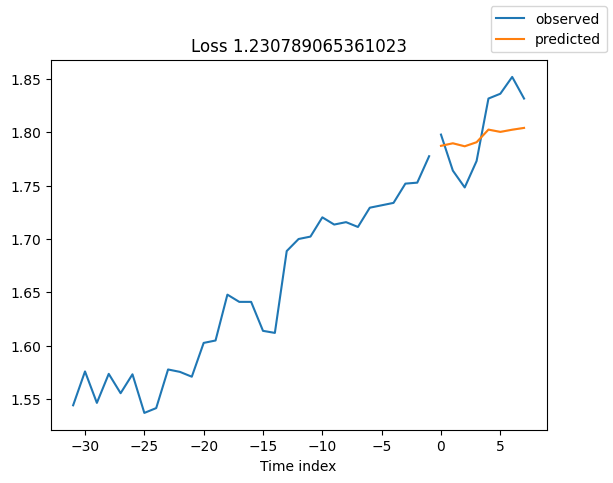

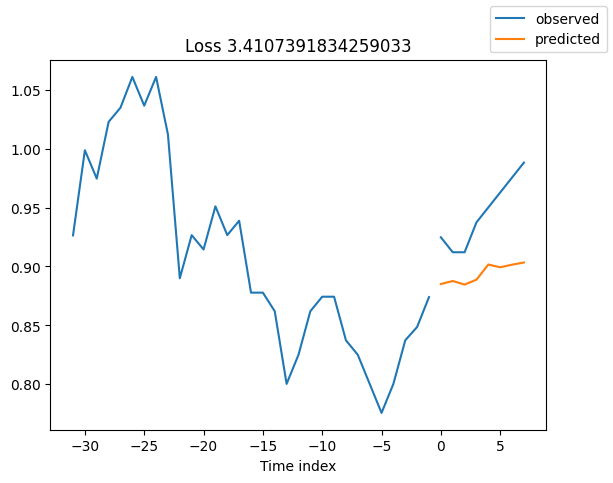

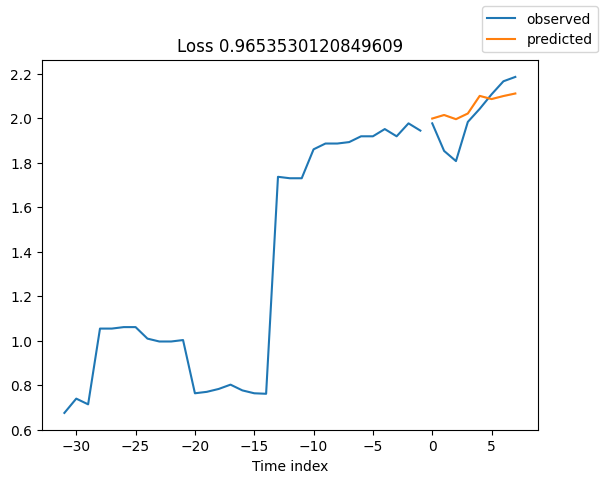

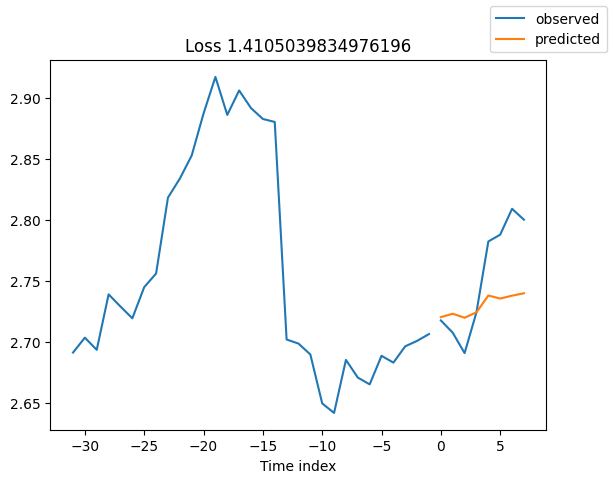

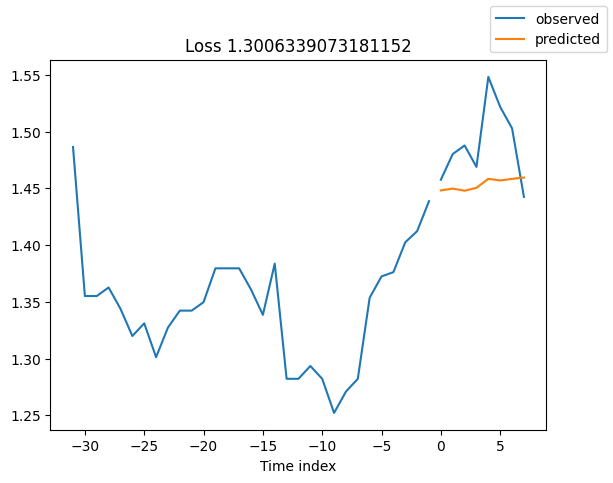

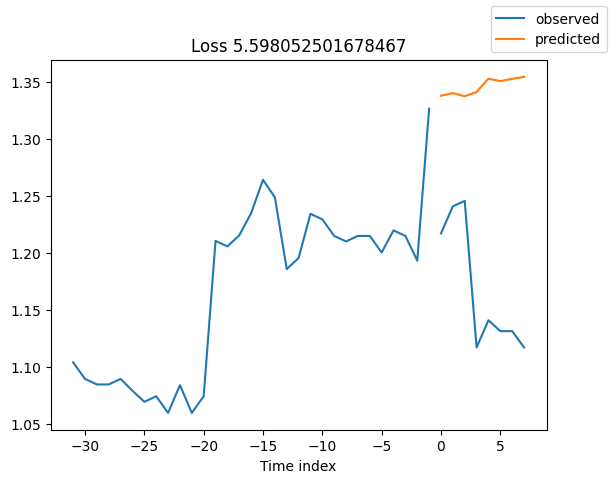

In [45]:
for idx in range(10):  # plot 10 examples
    net.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)